In [2]:
import pandas as pd
import os 
import glob 
import math 
import re
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib import patches as patches

In [3]:
# methods to plot objects in arenas

def plot_arena(ax):
    # arena: arena.world 
    ax.add_patch(patches.Rectangle((-5,-5), 1, 10, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((4,-5), 1, 10, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,-5), 10, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,4), 10, 1, edgecolor='lightgrey', facecolor='none'))

    
def plot_arena_large(ax):
    # arena: arena_large.world
    ax.add_patch(patches.Rectangle((-10,-10), 1, 20, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((9,-10), 1, 20, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,-10), 20, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,9), 20, 1, edgecolor='lightgrey', facecolor='none'))

    
def plot_two_rooms(ax): 
    # arena: two_rooms.world
    ax.add_patch(patches.Rectangle((-10,-8), 1, 16, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((9,-8), 1, 16, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-2,2), 1, 6, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-2,-8), 1, 6, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,7), 20, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,-8), 20, 1, edgecolor='lightgrey', facecolor='none'))

def plot_arena_corners(ax):
    # arena: arena_corners.world 
    ax.add_patch(patches.Rectangle((-5,-6), 1, 12, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((4,-6), 1, 12, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,-6), 10, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,5), 10, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-4,-3), 1, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((0,4), 1, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-4, 1.5), 1, 1.5, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((3, 0), 1, 2, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((2, -5), 2, 2, edgecolor='lightgrey', facecolor='none'))

def plot_arena_walls(ax):
    # arena: arena_walls.world
    ax.add_patch(patches.Rectangle((-7,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((6,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,-7), 14, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,6), 14, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((0,2), 0.25, 4, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((2,-0.75), 4, 0.25, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-2,-4), 0.25, 3, edgecolor='lightgrey', facecolor='none'))

def plot_turtle(ax):
    # arena: turtle.world 
    
    # ROS LOGO 
    ax.add_patch(patches.Circle((-1.1,-1.1), 0.15, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-1.1,0), 0.15, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-1.1,1.1), 0.15, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((0,-1.1), 0.15, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((0,0), 0.15, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((0,1.1), 0.15, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((1.1,-1.1), 0.15, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((1.1,0), 0.15, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((1.1,1.1), 0.15, edgecolor='lightgrey', facecolor='none'))
    
    # WALLS 
    
    
    # Turtle head etc. 
    

def plot_arena_corners_pillars(ax):
    # arena: arena_corners_pillars.world 
    ax.add_patch(patches.Rectangle((-5,-7), 10, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,6), 10, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((4,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-4,1), 1, 2, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((1,-6), 1, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((2,-6), 1, 2, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((3,-6), 1, 3, edgecolor='lightgrey', facecolor='none'))

    ax.add_patch(patches.Circle((-2,-3), 0.75, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((2,4), 0.75, edgecolor='lightgrey', facecolor='none'))
    

def plot_arena_walls_poles(ax):
    # arena: arena_walls_poles.world 
    ax.add_patch(patches.Rectangle((-7,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((6,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,-7), 14, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,6), 14, 1, edgecolor='lightgrey', facecolor='none'))    
    ax.add_patch(patches.Rectangle((-6,-0.875), 3, 0.25, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((0.875,2), 0.25, 4, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((5.875,-6), 0.25, 6, angle=45, edgecolor='lightgrey', facecolor='none'))
    
    ax.add_patch(patches.Circle((4,1), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((5,2), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-1,-4), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-2,-4), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-2,4), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-3,3), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-4,2), 0.05, edgecolor='lightgrey', facecolor='none'))

    
def plot_arena_pillars_poles(ax):
    # arena: arena_pillars_poles.world  
    ax.add_patch(patches.Rectangle((-7,3), 14, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((6,-3), 1, 6, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,-4), 14, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,-3), 1, 6, edgecolor='lightgrey', facecolor='none'))
    
    ax.add_patch(patches.Circle((-4,1), 0.4, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-1,-2), 1.2, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((1,2), 0.3, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((4,-1), 0.75, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((5.5,2.5), 0.5, edgecolor='lightgrey', facecolor='none'))


def plot_arena_pillars(ax):
    # arena: arena_pillars.world 
    ax.add_patch(patches.Rectangle((-10,-10), 1, 20, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((9,-10), 1, 20, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,-10), 20, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,9), 20, 1, edgecolor='lightgrey', facecolor='none'))
    
    ax.add_patch(patches.Circle((-4.5,4.5), 1.0, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-4.5,-4.5), 1.0, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((4.5,4.5), 1.0, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((4.5,-4.5), 1.0, edgecolor='lightgrey', facecolor='none'))
    
    
def plot_arena_poles(ax):
    # arena: arena_poles.world 
    ax.add_patch(patches.Rectangle((-7,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((6,-7), 1, 14, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,-7), 14, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,6), 14, 1, edgecolor='lightgrey', facecolor='none')) 
    
    ax.add_patch(patches.Circle((-2,-1), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-2,-2), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-2,-3), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((1,4), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((3,0), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((2,-4), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-2,-1), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((5.9,5.9), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-4,4), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-3,4), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-3,3.5), 0.05, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-4,3.5), 0.05, edgecolor='lightgrey', facecolor='none'))
    

def plot_arena_boxes_pillars(ax):
    # arena: arena_poles.world 
    ax.add_patch(patches.Rectangle((-7,4.5), 14, 1, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-7,-5.5), 14, 1, edgecolor='lightgrey', facecolor='none')) 
    ax.add_patch(patches.Rectangle((-7,-5.5), 1, 11, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((6,-5.5), 1, 11, edgecolor='lightgrey', facecolor='none'))
    
    ax.add_patch(patches.Circle((-0.5,2), 0.7, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Circle((-0.5,-2), 0.7, edgecolor='lightgrey', facecolor='none'))
    
    ax.add_patch(patches.Rectangle((-4,2), 1, 0.5, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-4,0.5), 1, 0.5, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-4,-1), 1, 0.5, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-4,-2.5), 1, 0.5, edgecolor='lightgrey', facecolor='none'))

    ax.add_patch(patches.Rectangle((2,2), 1, 0.5, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((2,0.5), 1, 0.5, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((2,-1), 1, 0.5, edgecolor='lightgrey', facecolor='none'))
    ax.add_patch(patches.Rectangle((2,-2.5), 1, 0.5, edgecolor='lightgrey', facecolor='none'))

    ax.add_patch(patches.Rectangle((4.25,-1), 0.75, 2, edgecolor='lightgrey', facecolor='none'))



In [4]:
# method to create visualization 

def create_plot(objects, robots, lidar, arena, r, robot, ax, rot_check):
    # create plot with robots, obstacles and lidar data 
    
    lidar_obj, lidar_kin = lidar
    
    ax.set_title(str(robot))
        
    if arena == 'arena':
        plot_arena(ax)
    elif arena == 'arena-large':
        plot_arena_large(ax)
    elif arena == "two-rooms":
        plot_two_rooms(ax) 
    elif arena == "arena-corners":
        plot_arena_corners(ax)
    elif arena == "arena-walls":
        plot_arena_walls(ax)
    elif arena == "arena-walls-poles":
        plot_arena_walls_poles(ax)
    elif arena == "arena-pillars-poles":
        plot_arena_pillars_poles(ax)
    elif arena == "arena-pillars":
        plot_arena_pillars(ax)
    elif arena == "arena-poles":
        plot_arena_poles(ax)
    elif arena == "arena-blocks-pillars":
        plot_arena_blocks_pillars(ax)
    elif arena == "turtle":
        plot_turtle(ax)
    elif arena == "arena-pillars":
        plot_arena_boxes_pillars(ax)        

    ax.scatter(*objects.T, facecolors='blue', marker='+') # objects except ground plane 
    ax.scatter(*robots.T, facecolors='none', edgecolors='orange') # robots 
    ax.scatter(*r.T, facecolors='green', edgecolors='green', marker='*') # robots 
    ax.scatter(*lidar_obj.T, s=0.5, color='red' if rot_check else 'blue') # lidar objects
    ax.scatter(*lidar_kin.T, s=0.5, color='red' if rot_check else 'orange') # lidar kins

In [5]:
# data frame processing 

def get_positions(df, idx):        
    # get object and robot positions from data frame 
    
    objects = [] 
    robots = [] 
    r = []
    angle = 0 
    
    # get object names  
    names = [el[1:-1] for el in df['poses'][idx].split('[')[1].split(']')[0].split(', ')] 

    string = df['poses'][idx]
    
    for i in range(0, len(names)):
        # get position 
        start = string.find('Point')
        stop = string[start:].find(')')
        pose = string[start+6:start+stop].split(', ')
        
        # get yaw angle (rotation around x-axis )
        string = string[start+6:]
        start = string.find('Quaternion')
        stop = string[start:].find(')')
        orientation = string[start+11:start+stop].split(', ')
        
        if names[i] == df['robot'][idx]: 
            r = [float(pose[0][2:]), float(pose[1][2:])]
            angle = calculate_yaw(orientation)            
        elif names[i][:5] == "robot" :
            robots.append([float(pose[0][2:]), float(pose[1][2:])])             
        elif names[i] != "ground_plane": 
            objects.append([float(pose[0][2:]), float(pose[1][2:])])
    
    return np.array(objects), np.array(robots), np.array(r), angle 


def calculate_yaw(orientation):
    # calculate yaw angle (around x-axis)
    
    q_x = float(orientation[0][2:])
    q_y = float(orientation[1][2:])
    q_z = float(orientation[2][2:])
    q_w = float(orientation[3][2:])

    siny_cosp = 2 * (q_w * q_z + q_x * q_y)
    cosy_cosp = 1 - 2 * (q_y * q_y + q_z * q_z)

    return np.arctan2(siny_cosp, cosy_cosp)

    
def transform_lidar(df, r, angle, idx, shift=0):  
    # transform lidar data from angle - distance to point 
    
    # get lidar data 
    ld = [float(el) for el in df['scan'][idx].split('ranges=[')[1].split('],')[0].split(',')]
        
    # transform lidar data to x, y positions 
        
    lidar = np.empty(shape=(360,2))

    for i in range(0, 360): 
        if not math.isinf(ld[i]):
            lidar[i][0] = ld[i] * math.cos(angle + np.deg2rad(i) + shift) + r[0]
            lidar[i][1] = ld[i] * math.sin(angle + np.deg2rad(i) + shift) + r[1]
        else: 
            lidar[i][0] = float('inf')
            lidar[i][1] = float('inf')
    
    return lidar, ld

In [28]:
# determine if lidar points belong to an object or kin based on gt position data

def detect_kin(robots, lidar):
    sel = np.zeros(len(lidar))
    for kin in range(len(robots)):
        robot = robots[kin]
        sel_robot = ((lidar - robot) ** 2).sum(-1) < 0.13 ** 2
        sel[sel_robot] = 1
    sel = sel.astype(bool)
    return lidar[~sel], lidar[sel], sel 

In [44]:
def detect_false_rotation(objects, arena, robots, r_self, lidar):
    match = np.zeros(len(lidar))
    match[np.isinf(lidar[:, 0])] = 1
    
    for kin in range(len(robots)):
        rob = robots[kin]
        # print(lidar.shape, rob.shape, r_self.shape, robots.shape)
        if ((r_self - rob) ** 2).sum(-1) > 16:
            continue
        match_kin = ((lidar - rob) ** 2).sum(-1) < 0.13 ** 2
        match[match_kin] = 1
    
    boundaries = []
    if arena == 'arena':
        boundaries = [(0, -4), (0, 4), (-4, 0), (4, 0)]
    elif arena == 'arena-large':
        boundaries = [(0, -9), (0, 9), (-9, 0), (9, 0)]
    elif arena == "two-rooms":
        boundaries = [(0, -7), (0, 7), (-9, 0), (9, 0)]
    elif arena == "arena-corners":
        boundaries = [(0, -5), (0, 5), (-4, 0), (4, 0)]
    elif arena == "arena-walls":
        boundaries = [(0, -7), (0, 7), (-7, 0), (7, 0)]
    elif arena == "arena-pillars":
        boundaries = [(0, -9), (0, 9), (-9, 0), (9, 0)]
    elif arena == "arena-poles":
        boundaries = [(0, -6), (0, 6), (-6, 0), (6, 0)]   
    #ToDo: other arenas and other objects 
    
    for bn in boundaries:
        bx, by = bn
        if bx == 0:
            match_bn = (lidar[:, 1] - by) ** 2 < 0.15 ** 2
        if by == 0:
            match_bn = (lidar[:, 0] - bx) ** 2 < 0.15 ** 2
        match[match_bn] = 1
        chk = match.mean() < 0.99
        match = match.astype(bool)
    return chk, lidar[~match], lidar[match]
    
    

robot ID: 0
robot position: [-1.34206696 -0.69080479]
corrected robot orientation: -2.8330255704913303
kin detection: 
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 Fals

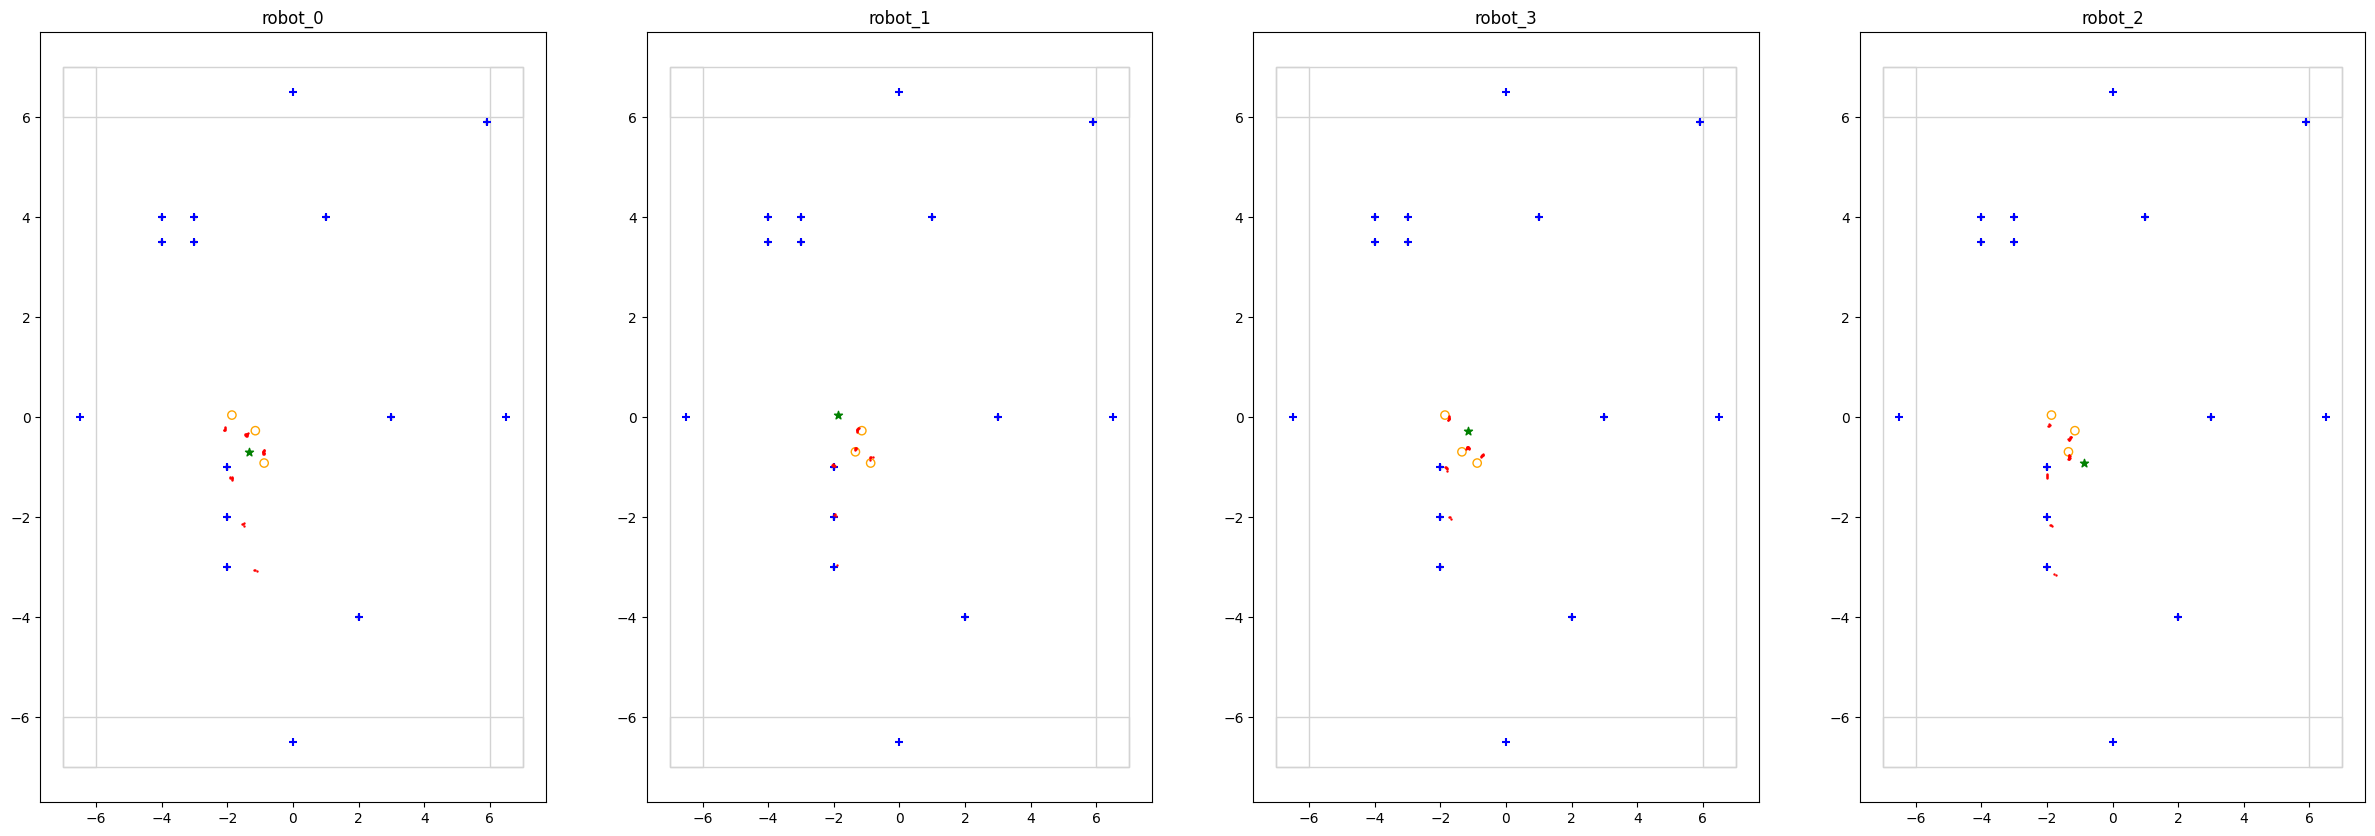

In [45]:
# main function: use to determine shifts for certain time stamps 

def main(idx=0, shift=[0,0,0,0,0,0,0,0,0]): 
    # get folders with rosbags / lidar data  
    subfolders = [f.name for f in os.scandir('./') if f.is_dir() and f.name[:5] == 'arena']

    for subfolder in subfolders: 
        files = glob.glob(subfolder+'/*.csv')
        arena = subfolder.split('_')[0]
        
        fig, axes = plt.subplots(1, len(files), figsize=(30, 10))

        for rob, f in enumerate(files):  
            
            df = pd.read_csv(f)

            # get robot and object positions 
            objects, robots, r, angle = get_positions(df, idx) 
            
            # transform lidar scans to points 
            lidar, ld = transform_lidar(df, r, angle, idx, shift[rob])
            
            # check for false rotation calculation
            rot_check, lm, lnm = detect_false_rotation(objects, arena, robots, r, lidar)
             
            # determine if object or kin
            l = detect_kin(robots, lidar)
            
            # create plot 
            create_plot(objects, robots, l[:2], arena, r, df['robot'][idx], axes[rob], rot_check)
            
            # prints data per robot: ID, position [x,y], orientation corrected by shift, kin detection per LiDAR ray 
            print("robot ID: " + str(rob))
            print("robot position: " + str(r))
            print("corrected robot orientation: " + str(angle + shift[rob]))
            print("kin detection: ")
            print(l[2])
            print("----")
        
        
if __name__ == "__main__":

    # shift specifies how much angle has to be adjusted per robot s.t. lidar data matches objects 
    main(idx=39, shift=[0.14,0,0,0,0,0,0,0,0])

In [ ]:
from tqdm import tqdm
# save all plots to create a gif

# get folders with rosbags / lidar data  
subfolders = [f.name for f in os.scandir('./') if f.is_dir() and f.name[:5] == 'arena']

print(subfolders)

for subfolder in subfolders: 
    files = glob.glob(subfolder+'/*.csv')
    arena = subfolder.split('_')[0]
    
    # Check whether the specified path for storing figures exists or not  
    path = "./figures/gt_figs/" + subfolder 
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    dfs = [pd.read_csv(f) for f in files]
    
    #only take 60 data points, leave first one out in case that not all positions were logged in the beginning
    for idx in tqdm(range(1, 61)): #range(len(dfs[0]['poses']))):
        
        fig, axes = plt.subplots(1, len(dfs), figsize=(30, 10))
        
        for rob, df in enumerate(dfs):  
        
            # get robot and object positions 
            objects, robots, r, angle = get_positions(df, idx) 
            s
            # transform lidar scans to points 
            lidar, ld = transform_lidar(df, r, angle, idx, shift=0)

            # check for false rotation calculation
            rot_check, lm, lnm = detect_false_rotation(objects, arena, robots, r, lidar)
            # lidar = (lm, lnm)

            # determine if object or kin
            lidar = detect_kin(robots, lidar)
            
            # create plot 
            create_plot(objects, robots, lidar, arena, r, df['robot'][idx], axes[rob], rot_check)
            
        plt.savefig("./figures/gt_figs/" + re.sub('\\\\.*$', '', files[0]) + "_%d.png" % (idx,))
        plt.close()

In [ ]:
subfolders = [f.name for f in os.scandir('./') if f.is_dir() and f.name[:1] != '.' and f.name[:5] == 'arena']
subfolders